<a href="https://colab.research.google.com/github/RozitaAbdoli/credit_default_mining/blob/main/Model_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Comparing the performance of multiple ML algorithms
In this notebook, the performance of several ML algorithms will be evaluated based on their effectiveness, efficiency, and stability.

The ML models include Random Forest, Adaptive Boost, and Gradient Boost ensemble learners that use Decision Trees as weak learners. They:  

* Are non-parametric and don't require data to be normally distributed.
* Can handle both numeric and categorical data types, and categorical predictors don't have to be one-hot encoded.
* The correlation between predictors does not affect the performance of the model.



In [9]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
# from sklearn.neural_network import MLPClassifier
# from sklearn import svm
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, f1_score, brier_score_loss

import time

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate
# from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

In [10]:
#Change the global figure parameters using pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 22,
         'axes.titlesize':'x-large',
         'xtick.labelsize':18,
         'ytick.labelsize':18}
pylab.rcParams.update(params)

In [11]:
# #Import Drive API and authenticate
# from google.colab import drive
# #Mount Drive to the Colab VM
# drive.mount('/content/drive')

In [12]:
#Load the dataset into pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/Capstone_project/v2_credit_default.csv")

In [13]:
# #  Selected features Based on Pearson and Spearman's rank correlations with the dependent variable, and XGBoost feature importance rankings:
# df = df[['AGE', 'LIMIT_BAL', 'Pay_Apr', 'Repay_Sept', 'Pay_Sept','Default' ]]

In [14]:
df.shape

(29965, 24)

In [15]:
#Seperate the independent and dependent variables.
X = df.drop(['Default'], axis=1)
y = df['Default']

## 1. Cross-validation step:    

In [16]:
#List the classifiers to be compared
names = ["Logistic Regression","KNN", "Naive Bayes", "Decision Tree", "Random Forest", "AdaBoost", "GradientBoost", "XGBoost"]  

clfs = [
    LogisticRegression(random_state=1, C= 50, penalty= 'l1', solver= 'liblinear'),
    KNeighborsClassifier(),                           #n_neighbors=5 
    GaussianNB(),
    # svm.SVC(kernel ='rbf'),               #SVM model does not have the best performance, but takes a long time, therefore ommited here.
    DecisionTreeClassifier(),              #set max_depth 
    RandomForestClassifier(),        #bootstrap aggregation or bagging
    AdaBoostClassifier(), 
    GradientBoostingClassifier(),    #also tried GridSearchCV result {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 200}
    XGBClassifier() 
] 

In [17]:
# Calculate metrics, as well as their standard deviations to see how stable are the models.
accuracies = []
accuracy_stds = []
precisions = []
precision_stds = []
recalls = []
recall_stds = []
f1_scores = []
f1_stds = []
roc_aucs = []
auc_stds = []
# neg_brier_scores = []

elapsed_time = []

cv = RepeatedKFold(n_splits=10, n_repeats=5)    #5 repeats of k=10-fold     #random_state=1
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc' }

for name, clf in zip(names, clfs):
    start = time.time()

    scores = cross_validate(clf, X, y, scoring=scoring, cv=cv)

    end = time.time()
    elapsed = end - start
    elapsed_time.append(elapsed)

    accuracies.append(mean(scores['test_accuracy']))
    accuracy_stds.append(std(scores['test_accuracy']))

    precisions.append(mean(scores['test_precision']))
    precision_stds.append(std(scores['test_precision']))

    recalls.append(mean(scores['test_recall']))
    recall_stds.append(std(scores['test_recall']))

    f1_scores.append(mean(scores['test_f1']))
    f1_stds.append(std(scores['test_f1']))

    roc_aucs.append(mean(scores['test_roc_auc']))
    auc_stds.append(std(scores['test_roc_auc']))

In [18]:
# Performance metrics dataframe with cross validation
CV_scores_df = pd.DataFrame()
CV_scores_df['Algorithm'] = names

CV_scores_df['Accuracy'] = accuracies
CV_scores_df['Accuracy_SD'] = accuracy_stds

CV_scores_df['Precision'] = precisions
CV_scores_df['Precision_SD'] = precision_stds

CV_scores_df['Recall'] = recalls
CV_scores_df['Recall_SD'] = recall_stds

CV_scores_df['F1_score'] = f1_scores 
CV_scores_df['F1_SD'] = f1_stds 

CV_scores_df['ROC_AUC'] = roc_aucs  
CV_scores_df['AUC_SD'] = auc_stds 

CV_scores_df['Elapsed_time'] = elapsed_time

CV_scores_df

,Algorithm,Accuracy,Accuracy_SD,Precision,Precision_SD,Recall,Recall_SD,F1_score,F1_SD,ROC_AUC,AUC_SD,Elapsed_time
0,Logistic Regression,0.810579,0.006787,0.715042,0.030737,0.239458,0.016784,0.358419,0.020378,0.722862,0.012326,32.166466
1,KNN,0.754127,0.005904,0.384468,0.023723,0.185314,0.015404,0.249849,0.017650,0.609269,0.010663,40.950794
2,Naive Bayes,0.379082,0.011968,0.247568,0.007469,0.885467,0.014073,0.386883,0.009421,0.671867,0.012120,1.475243
3,Decision Tree,0.723124,0.007471,0.382635,0.017163,0.409874,0.020159,0.395625,0.016801,0.611421,0.010765,36.660814
4,Random Forest,0.815225,0.006251,0.643726,0.020257,0.369206,0.019019,0.468991,0.018007,0.763555,0.010025,427.274134
5,AdaBoost,0.816766,0.006644,0.682368,0.023590,0.321569,0.017732,0.436860,0.018929,0.774040,0.010601,133.584536
6,GradientBoost,0.821332,0.006834,0.678256,0.023388,0.365927,0.019323,0.475177,0.020188,0.781927,0.011081,596.648550
7,XGBoost,0.821492,0.006855,0.681275,0.025089,0.363395,0.016136,0.473722,0.016592,0.782280,0.009028,141.755913


In [ ]:
# visual representation of the performance metrics above
CV_scores_df.plot(x="Algorithm", y=["Accuracy", "Precision", "Recall"], kind="bar", yerr=[df.mean()-df.min(), df.max()-df.mean()]);
plt.ylim([0, 1])
plt.legend(loc="upper right", ncol=len(df.columns))
plt.xlabel(None)
plt.ylabel("Percent")
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

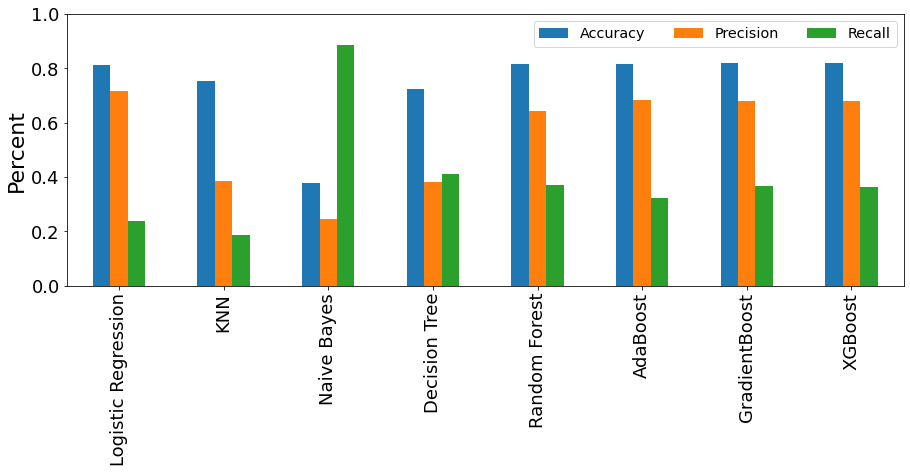

In [19]:
# visual representation of the performance metrics above
CV_scores_df.plot(x="Algorithm", y=["Accuracy", "Precision", "Recall"], kind="bar");
plt.ylim([0, 1])
plt.legend(loc="upper right", ncol=len(df.columns))
plt.xlabel(None)
plt.ylabel("Percent")
plt.xticks(rotation=90)

## 2. Classic train-test step on the best performing model:    

In [20]:
# Now the classic train-test split, but iterated 50 times. This will be slower than CV, and therefore is only done for the best-performing model.
# The test set is unseen by the model, and therefore there is no chance of knowledge leaking.
# If everything has gone right, this model should perform the same with train-test split here as it did with cross-validation above.
accuracies = []
precisions = []
recalls = []
f1s = []
aucs = []

for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    RFC = RandomForestClassifier()

    RFC.fit(X_train, y_train)
    y_pred = RFC.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    y_pred_proba = RFC.predict_proba(X_test)[::, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    aucs.append(auc)

print(mean(accuracies),
      mean(precisions),
      mean(recalls),
      mean(f1s),
      mean(aucs)
      )

0.8148565072302558 0.6450870688962711 0.36913369799226237 0.4694354851378707 0.7621416779585176


In [21]:
#classic train-test split, now with normalization of the training data
#conclusion: normalization of the training data did not make a big difference

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)    #To ignore the Future Warning that is raised with SMOTETomek()

accuracies = []
precisions = []
recalls = []
f1s = []
aucs = []

for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    RFC = RandomForestClassifier()

    X_train, y_train = SMOTETomek().fit_sample(X_train, y_train) 
    RFC.fit(X_train, y_train)
    y_pred = RFC.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    y_pred_proba = RFC.predict_proba(X_test)[::, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    aucs.append(auc)

print(mean(accuracies),       #0.7839577308120134 0.5103448244191694 0.4883777609994461 0.49904917463462584 0.7504290414514017
      mean(precisions),
      mean(recalls),
      mean(f1s),
      mean(aucs)
      )

0.7843203559510568 0.5099171044228323 0.4897119744085694 0.49951846063596006 0.7506161661624149


______________________________


## 3. (optional) Train-test step with every model:    
* Can calculate model efficiency (time it takes to train the model)
* Can see if there are models, other than the top-performing model above, that might benefit from data engineering (balancing, normalizing) and would be woth exploring further.

In [22]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)   #random_state=1

In [23]:
# # Scale X_train
# X_train = preprocessing.MinMaxScaler().fit_transform(X_train)

In [24]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Balance the training data using SMOTE Tomek
X_train, y_train = SMOTETomek(random_state=1).fit_sample(X_train, y_train)   

In [26]:
#Put the column headers back after engineering the training data
X_train = pd.DataFrame(X_train)
X_train.columns = X.columns
y_train = pd.DataFrame(y_train)
y_train=y_train.rename(columns = {0:'Default'})

In [27]:
#An alternative, less robust but faster option is to have training on the training set, and testing on the test set (no validation set).
# This will only give us 1 number for each performance metric.
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []
# neg_brier_scores = []

elapsed_time = []

for name, clf in zip(names, clfs):
    start = time.time()

    clf.fit(X_train, y_train)

    end = time.time()
    elapsed = end - start
    elapsed_time.append(elapsed)

    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    precision = precision_score(y_test, y_pred)
    precisions.append(precision)

    recall = recall_score(y_test, y_pred)
    recalls.append(recall)

    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

    roc_auc = roc_auc_score
    roc_aucs.append(roc_auc)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
 

In [28]:
#Precision= TP/(TP+FP), Recall= TP/(TP+FN)
scores_df = pd.DataFrame()
scores_df['Algorithm'] = names
scores_df['Accuracy'] = accuracies
scores_df['Precision'] = precisions
scores_df['Recall'] = recalls
scores_df['F1_score'] = f1_scores
scores_df['Elapsed-time(s)'] = elapsed_time
scores_df

,Algorithm,Accuracy,Precision,Recall,F1_score,Elapsed-time(s)
0,Logistic Regression,0.700000,0.379195,0.571573,0.455921,1.221296
1,KNN,0.603782,0.286331,0.537178,0.373549,0.144841
2,Naive Bayes,0.331034,0.238502,0.931209,0.379744,0.020183
3,Decision Tree,0.686763,0.343412,0.465352,0.395189,0.711532
4,Random Forest,0.783537,0.508683,0.459282,0.482722,8.587957
5,AdaBoost,0.731368,0.417978,0.564492,0.480310,3.473156
6,GradientBoost,0.762069,0.464935,0.543247,0.501050,16.014765
7,XGBoost,0.763849,0.468122,0.542236,0.502461,3.475336


Some notes:

* Scaling inputs between 0 and 1 did not affect the performance of the models much.
* Can see the trade-off between precision and recall in this algorithms: when precision is high recall suffers, and vice versa.

In [29]:
#Plot all attribues as subplots
# scores_df.plot(x="Algorithm", y=["Accuracy", "Precision", "Recall", "Elapsed-time(s)"], subplots=True)
# plt.show()

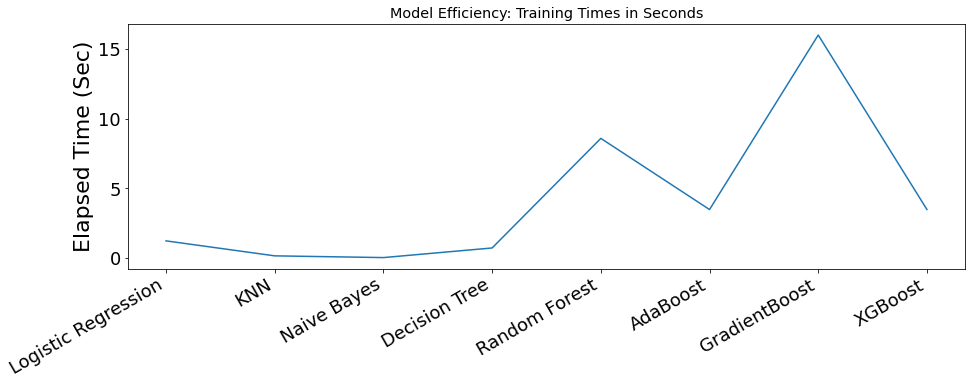

In [30]:
# Plotting the time it took each model to train
scores_df.plot(x="Algorithm", y=["Elapsed-time(s)"], subplots=True, legend=None)
plt.xlabel(xlabel=None)
plt.ylabel('Elapsed Time (Sec)')
plt.title('Model Efficiency: Training Times in Seconds')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

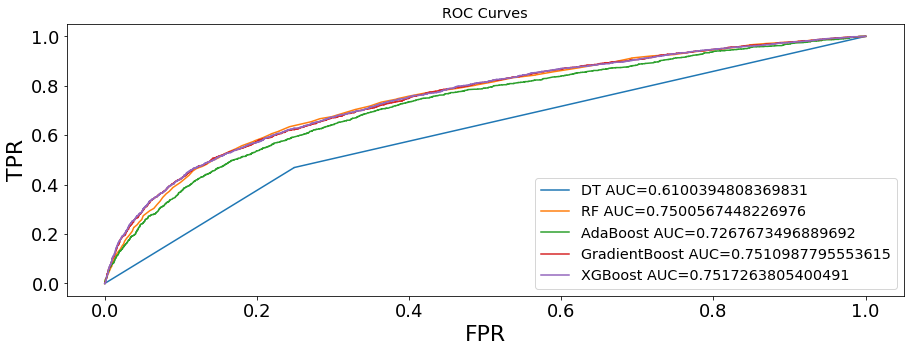

In [31]:
# The ROC curves and the ROC AUC

dtc = DecisionTreeClassifier()              #set max_depth 
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
y_pred_proba = dtc.predict_proba(X_test)[::,1] 
FPR, TPR, _ = roc_curve(y_test, y_pred_proba)            #roc_curve(y_true, y_score)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(FPR,TPR,label="DT AUC="+str(auc))

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
y_pred_proba = rfc.predict_proba(X_test)[::,1] 
FPR, TPR, _ = roc_curve(y_test, y_pred_proba)            #roc_curve(y_true, y_score)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(FPR,TPR,label="RF AUC="+str(auc))


abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
y_pred = abc.predict(X_test)
y_pred_proba = abc.predict_proba(X_test)[::,1] 
FPR, TPR, _ = roc_curve(y_test, y_pred_proba)            #roc_curve(y_true, y_score)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(FPR,TPR,label="AdaBoost AUC="+str(auc))

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
y_pred_proba = gbc.predict_proba(X_test)[::,1] 
FPR, TPR, _ = roc_curve(y_test, y_pred_proba)            #roc_curve(y_true, y_score)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(FPR,TPR,label="GradientBoost AUC="+str(auc))


xgbc = XGBClassifier() 
xgbc.fit(X_train, y_train)
y_pred = xgbc.predict(X_test)
y_pred_proba = xgbc.predict_proba(X_test)[::,1] 
FPR, TPR, _ = roc_curve(y_test, y_pred_proba)            #roc_curve(y_true, y_score)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(FPR,TPR,label="XGBoost AUC="+str(auc))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves')
plt.legend(loc=4) 
plt.show()

## 4. Comparing feature importances

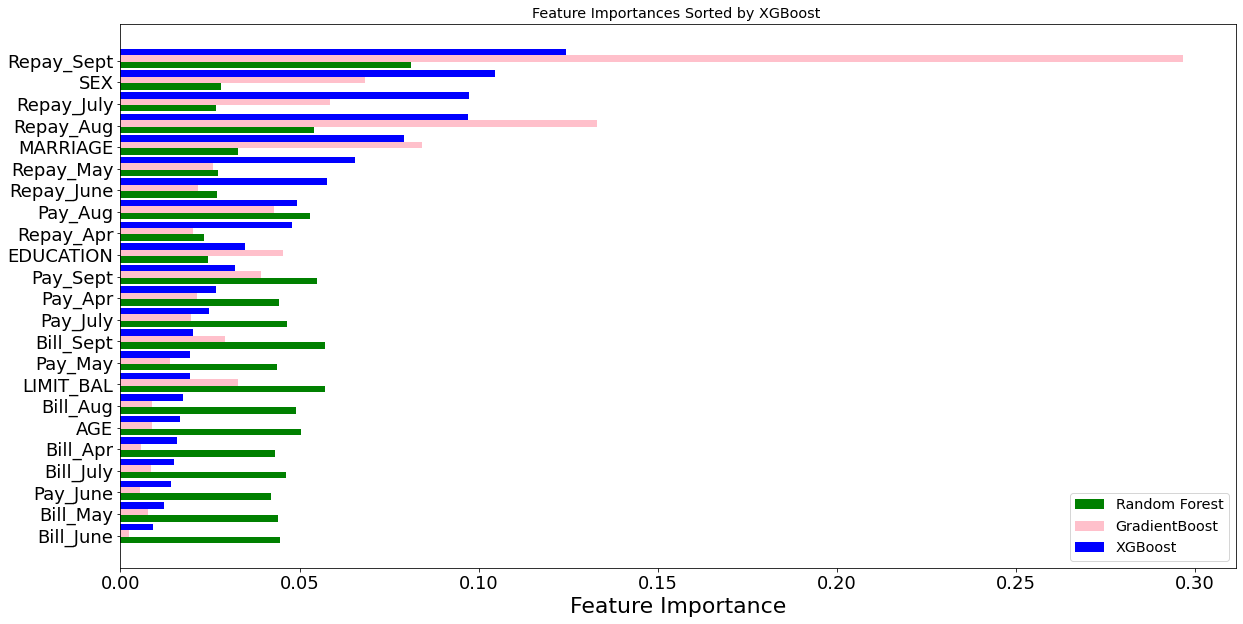

In [67]:
#plot feature importances for the top 3 models
# dt, rfc, abc, and gbc models already defined and fit in the code cell for ROC curves
feature_importance=pd.DataFrame({
    'rfc':rfc.feature_importances_,
    'gbc':gbc.feature_importances_,
    'xgbc':xgbc.feature_importances_
},
index=df.drop(columns=['Default']).columns)

feature_importance.sort_values(by='xgbc',ascending=True,inplace=True)

index = np.arange(len(feature_importance))
fig, ax = plt.subplots(figsize=(20,10))

rfc_feature=ax.barh(index+0.3,feature_importance['rfc'],0.3,color='green',label='Random Forest')
gbc_feature=ax.barh(index+0.6,feature_importance['gbc'],0.3,color='pink',label='GradientBoost')
xgbc_feature=ax.barh(index+0.9,feature_importance['xgbc'],0.3,color='blue',label='XGBoost')

ax.set(yticks=index+0.5,yticklabels=feature_importance.index)

plt.title("Feature Importances Sorted by XGBoost ")
plt.xlabel('Feature Importance')
plt.legend(loc=4)
plt.show()